<img src="Liv4_Signal_HEADER.png" style="width: 100%; height: auto;">

# SOMMAIRE
1. [Presentation du groupe](#Presentation-du-groupe)
2. [Rappel du contexte](#Rappel-du-contexte)
3. [Presentation du code](#Presentation-du-code)
4. [Conclusion](#Conclusion)

# Presentation du groupe
## Membres du groupe:
- **///**
- **///**
- **///**
- **///**

# Rappel du contexte
L'agence AIL3C, spécialisée dans la lutte contre la cybercriminalité, développe des technologies pour aider ses agents. Actuellement, nous travaillons sur un projet suite à la perte de l'agent K57, qui a été piégé dans une salle sans réseau pendant une mission. Cette situation met en évidence le besoin d'une solution pour permettre la communication dans de telles conditions.

<div style="text-align: left;">
   <img src="MainLOGO.png" style="width:20%; height:auto;">
</div>

# Presentation du code


## Variables Globales

#### C'est quoi un thread en Python ?
En Python, un thread (ou fil d’exécution) est une unité d’exécution qui permet d’exécuter plusieurs tâches simultanément dans un même programme. Il est utilisé pour améliorer la réactivité et optimiser les performances des applications en exécutant certaines opérations en arrière-plan.

Ici, on utilise un thread pour faire fonctionner deux systèmes en même temps (génération du son modulé par le PC 1 / écoute du son par le PC 2).

In [ ]:
# Variables de stockage pour les threads des "PCs" dans la partie de test de l'écoute
ThreadPC2 = None  # Thread pour le PC 1



## Convertion ASCII/Binaire

#### Comment convertir du binaire en ASCII ?
En Python, on peut convertir du texte en binaire et inversement en utilisant les fonctions ord() et chr().

Texte → Binaire : On transforme chaque caractère en son code ASCII, puis en binaire.

Binaire → Texte : On regroupe les bits par 8 pour retrouver les caractères correspondants.

In [175]:
# Convertir une chaîne de texte en une liste de bits individuels (liste 1D)
def texte_en_binaire(texte):
    """
    Convertit une chaîne de caractères en une liste de bits (1D).
    Chaque caractère est représenté sur 8 bits.
    """
    return [int(bit) for c in texte for bit in format(ord(c), '08b')]  # Convertir chaque caractère en binaire et aplatir la liste

# Convertir une liste de bits individuels en une chaîne de texte
def binaire_en_texte(liste_bits):
    """
    Convertit une liste de bits (1D) en une chaîne de caractères ASCII.
    Chaque groupe de 8 bits est transformé en un caractère.
    """
    binary_chars = [''.join(map(str, liste_bits[i:i+8])) for i in range(0, len(liste_bits), 8)]  # Regrouper les bits par blocs de 8
    return ''.join(chr(int(b, 2)) for b in binary_chars)  # Convertir chaque bloc en caractère ASCII


## Ajout/Retrait trame (Avec CRC)

### C'est quoi une trame ?
En communication numérique, une trame est une unité de transmission de données structurée. Elle contient des informations utiles ainsi que des données de contrôle pour assurer une transmission fiable.

Une trame est généralement composée de plusieurs parties :

En-tête (Header) : Contient des informations comme l’adresse source et destination.
Données (Payload) : Contient le message à transmettre.
Checksum ou CRC : Permet de détecter les erreurs de transmission.

In [176]:
def calculate_crc(message_bits):
    """
    Calcul d'un CRC simple basé sur une opération XOR pour des données binaires.
    """
    crc = 0
    for bit in message_bits:
        crc ^= bit  # Opération XOR sur chaque bit
    return crc

def add_trame_to_message(message_bits):
    """
    Ajoute une trame au message binaire :
    Structure : [Préfixe][ID][Message][Suffixe][CRC]
    """
    prefix = [0, 1]           # Drapeau de début (2 bits)
    message_id = [1, 0, 0, 1] # ID du message (4 bits)
    suffix = [1, 0]           # Drapeau de fin (2 bits)

    # Assemblage des différentes parties du message
    message_with_trame = prefix + message_id + message_bits + suffix

    # Calcul du CRC
    crc = calculate_crc(message_with_trame)
    crc_bits = [int(x) for x in format(crc, '08b')]  # Conversion du CRC en 8 bits (1 octet)

    # Trame finale avec CRC
    full_trame = message_with_trame + crc_bits
    return full_trame

def retrieve_message_from_trame(trame):
    """
    Extrait le message original de la trame reçue et valide le CRC.
    """
    # Extraction du CRC (les 8 derniers bits)
    received_crc_bits = trame[-8:]
    message_with_crc = trame[:-8]

    # Calcul du CRC pour validation
    calculated_crc = calculate_crc(message_with_crc)
    received_crc_value = int(''.join(map(str, received_crc_bits)), 2)

    print(f"📥 CRC reçu : {received_crc_value} | 🛠️ CRC calculé : {calculated_crc}")

    if received_crc_value == calculated_crc:
        print("✅ CRC validé avec succès.")

        # Extraction des différentes parties du message
        prefix = message_with_crc[:2]         # Préfixe de 2 bits
        message_id = message_with_crc[2:6]    # ID du message (4 bits)
        message_bits = message_with_crc[6:-2] # Message réel
        suffix = message_with_crc[-2:]        # Suffixe de 2 bits

        return message_bits
    else:
        print("❌ Erreur de CRC, message corrompu.")
        return None


## Codage/Décodage Manchester

#### Comment coder l'information en Manchester et pourquoi ?
##### Principe du codage Manchester
Le codage Manchester est une technique de modulation utilisée en transmission numérique. Chaque bit est représenté par une transition au milieu de la période du signal :

Bit 0 → Transition de haut à bas (1 → 0)
Bit 1 → Transition de bas à haut (0 → 1)

#### Pourquoi utiliser le codage Manchester ?
Le codage Manchester présente plusieurs avantages :

✅ Auto-synchronisation : La transition en milieu de bit permet de synchroniser l'émetteur et le récepteur sans signal d’horloge supplémentaire.

✅ Détection des erreurs facilitée : Toute absence de transition indique une erreur de transmission.

✅ Évite les longues séquences de 0 ou 1 : Contrairement au codage NRZ, il empêche les niveaux continus qui posent problème aux systèmes de transmission.

📌 Utilisation courante : Ethernet, RFID, et certaines transmissions radio utilisent le codage Manchester pour sa fiabilité.

In [177]:
def codage(binary):
    """
    Applique le codage Manchester à une séquence binaire.
    
    Règle du codage Manchester :
    - Un bit '1' est représenté par la séquence [0,1]
    - Un bit '0' est représenté par la séquence [1,0]
    
    Ce codage assure une transition à chaque bit, ce qui facilite la synchronisation.
    """
    return [bit for b in binary for bit in ([0, 1] if b == 1 else [1, 0])]


def decodage(binary):
    """
    Décode une séquence binaire Manchester.
    
    - Chaque bit est représenté par deux valeurs successives.
    - Si la première valeur est inférieure à la deuxième (0 → 1), alors c'est un '1'.
    - Si la première valeur est supérieure à la deuxième (1 → 0), alors c'est un '0'.
    
    Le décodage se fait en lisant les bits deux par deux.
    """
    return [1 if binary[i] < binary[i + 1] else 0 for i in range(0, len(binary)-1, 2)]


## Modulation/Démodulation ASK

#### Modulation et Démodulation ASK
1.Qu'est-ce que la modulation ASK ?
La modulation d’amplitude en déplacement d’amplitude (ASK - Amplitude Shift Keying) est une technique de modulation où l’amplitude d’une onde porteuse est modifiée en fonction du signal binaire à transmettre.

Bit 1 → L’onde porteuse est présente avec une amplitude maximale.

Bit 0 → L’onde porteuse est absente ou a une amplitude réduite.

Cela permet de convertir un signal numérique en un signal analogique adapté à la transmission par un canal (radio, fibre optique, etc.).

2.Qu'est-ce que la démodulation ASK ?

La démodulation ASK est le processus inverse : 
elle récupère l'information binaire à partir du signal modulé. Pour cela, le récepteur détecte les variations d'amplitude de la porteuse 

Si l’amplitude du signal est élevée, le bit reçu est 1.

Si l’amplitude du signal est faible ou nulle, le bit reçu est 0.

La démodulation ASK peut être réalisée par différentes méthodes :

✔ Détection enveloppe (filtrage et détection de l’amplitude).

✔ Détection cohérente (multiplication avec une réplique de la porteuse et filtrage).

3. Avantages et inconvénients

✅ Simple à implémenter et peu coûteuse.

✅ Efficace pour des transmissions à courte distance.

❌ Sensibilité élevée aux interférences et au bruit, ce qui peut provoquer des erreurs.

❌ Consommation d’énergie importante en comparaison à d’autres modulations comme FSK ou PSK.

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

def ModulationASK(BinaryDATA=None, Fp=500, baud=2):
    """
    Fonction de modulation ASK (Amplitude Shift Keying).
    """
    Fe = 50000  # Fréquence d'échantillonnage
    
    Nbits = len(BinaryDATA)  # Nombre de bits du signal
    Ns = int(Fe / baud)  # Nombre d'échantillons par bit
    N = Ns * Nbits  # Nombre total d'échantillons
    M_Dup = np.repeat(BinaryDATA, Ns)  # Répétition des bits pour échantillonnage
    t = np.arange(0, N / Fe, 1 / Fe)  # Axe temporel
    
    Porteuse = np.sin(2 * np.pi * Fp * t)  # Signal de la porteuse
    
    ASK = np.multiply(Porteuse, M_Dup)  # Signal modulé ASK
    
    # Affichage du signal binaire d'origine
    plt.ion()
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)  # Premier sous-graphique pour les données binaires
    plt.plot(t, M_Dup, drawstyle='steps-post', color='r', linewidth=2)
    plt.xlabel("Temps (s)")
    plt.ylabel("Valeur binaire")
    plt.title("Données binaires d'origine (après np.repeat)")
    plt.ylim(-0.2, 1.2)
    plt.grid(True)

    # Affichage du signal ASK modulé
    plt.subplot(2, 1, 2)
    plt.plot(t, ASK)
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title("Signal modulé ASK")

    plt.draw()

    return ASK

def DemodulationASK(DATA, Fp=500, baud=2):
    """
    Fonction de démodulation ASK (Amplitude Shift Keying).
    """
    Fe = 50000  # Fréquence d'échantillonnage
    
    Limit = np.max(DATA) / 2  # Seuil de détection du signal
    for i in DATA:
        if i < Limit:
            i = 0  # Suppression du bruit en dessous du seuil
    
    Ns = int(Fe / baud)  # Nombre d'échantillons par bit
    Nbits = len(DATA) / Ns  # Nombre total de bits
    N = len(DATA)  # Nombre total d'échantillons
    t = np.arange(0, N / Fe, 1 / Fe)  # Axe temporel
    
    Porteuse = np.sin(2 * np.pi * Fp * t)  # Signal de la porteuse
    Produit = np.abs(DATA)  # Prise de la valeur absolue du signal reçu
    y = []  # Liste pour stocker les valeurs intégrées    

    # Intégration du signal sur chaque période de bit
    for i in range(0, N, Ns):
        y.append(np.trapezoid(Produit[i:i+Ns], t[i:i+Ns]))
    
    # Seuil pour décider entre 0 et 1
    message_demodule = np.array(y) > 0.09  

    # Décodage du signal démodulé
    message_recu_decode = []
    for ii in range(len(message_demodule)):
        if message_demodule[ii] > 0:
            message_recu_decode.append(1)
        else:
            message_recu_decode.append(-1)

    # Conversion des valeurs -1 en 0 pour obtenir un signal binaire
    message_recu_bin = [0 if i == -1 else 1 for i in message_recu_decode]

    return message_recu_bin


## Modulation/Démodulation FSK

#### **Modulation et Démodulation FSK**

##### **1. Qu'est-ce que la modulation FSK ?**
La **modulation par déplacement de fréquence (FSK - Frequency Shift Keying)** est une technique de modulation où la fréquence de l'onde porteuse varie en fonction du signal binaire à transmettre.

- **Bit 1** → La porteuse a une fréquence \( F_1 \).
- **Bit 0** → La porteuse a une fréquence \( F_2 \).

Cette variation de fréquence permet de représenter l’information binaire sous forme d’un signal analogique, facilitant ainsi sa transmission.

##### **2. Qu'est-ce que la démodulation FSK ?**
La **démodulation FSK** consiste à récupérer l'information binaire à partir du signal modulé en détectant les variations de fréquence.

 **Méthodes courantes** :
✔ **Détection par filtre passe-bande** : Chaque fréquence est filtrée séparément, puis on compare leurs amplitudes pour déterminer si le bit reçu est un 1 ou un 0.  
✔ **Détection cohérente** : Multiplication du signal reçu avec des signaux de référence et filtrage.  
✔ **Transformée de Fourier (FFT)** : Analyse des fréquences dominantes sur des intervalles de temps.

##### **3. Avantages et inconvénients**
✅ **Moins sensible au bruit et aux interférences** que la modulation ASK.  
✅ **Utilisée dans des environnements où la transmission peut être perturbée** (radio, Bluetooth, modems, etc.).  
❌ **Nécessite plus de bande passante** qu’ASK.  
❌ **Implémentation plus complexe** qu’ASK.




In [216]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

def ModulationFSK(BinaryDATA=None, Fp1=19000, Fp2=20000, baud=2):
    """
    Modulation FSK (Frequency Shift Keying).

    - Un '1' est représenté par une fréquence Fp1.
    - Un '0' est représenté par une fréquence Fp2.
    
    Paramètres :
    - BinaryDATA : Liste des bits à moduler.
    - Fp1 : Fréquence utilisée pour les '1' (par défaut 19 kHz).
    - Fp2 : Fréquence utilisée pour les '0' (par défaut 20 kHz).
    - baud : Débit binaire en bauds (par défaut 2 bauds).

    Retourne :
    - Signal FSK modulé.
    """
    Fe = 50000  # Fréquence d'échantillonnage

    Nbits = len(BinaryDATA)  # Nombre de bits
    Ns = int(Fe / baud)  # Nombre d'échantillons par bit
    N = Ns * Nbits  # Nombre total d'échantillons

    M_Dup = np.repeat(BinaryDATA, Ns)  # Répétition des bits pour s’adapter à l’échantillonnage
    binary_data = np.array(M_Dup)  
    inverted_data = 1 - binary_data  # Inversion pour obtenir les '0'

    t = np.arange(0, N / Fe, 1 / Fe)  # Axe temporel

    Porteuse1 = np.sin(2 * np.pi * Fp1 * t)  # Porteuse pour les '1'
    Porteuse2 = np.sin(2 * np.pi * Fp2 * t)  # Porteuse pour les '0'

    # Multiplication du signal binaire avec les porteuses correspondantes
    Port1mult = np.multiply(Porteuse1, binary_data)
    Port2mult = np.multiply(Porteuse2, inverted_data)

    FSK = np.add(Port1mult, Port2mult)  # Addition des deux signaux pour obtenir la modulation FSK

    # Affichage des signaux
    plt.ion()
    plt.figure(figsize=(12, 8))

    # Signal binaire original
    plt.subplot(2, 1, 1)
    plt.plot(t, M_Dup, drawstyle='steps-post', color='r', linewidth=2)
    plt.xlabel("Temps (s)")
    plt.ylabel("Valeur Binaire")
    plt.title("Données Binaires Originales (Après np.repeat)")
    plt.ylim(-0.2, 1.2)
    plt.grid(True)

    # Signal modulé FSK
    plt.subplot(2, 1, 2)
    plt.plot(t, FSK)
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title("Signal Modulé FSK")

    plt.draw()

    return FSK


def DemodulationFSK(FSK, Fp1=19000, Fp2=20000, baud=2):
    """
    Démodulation FSK (Frequency Shift Keying).
    
    - Le signal reçu est multiplié par les deux fréquences de référence.
    - On compare l'énergie pour déterminer la fréquence dominante et en déduire les bits.

    Paramètres :
    - FSK : Signal FSK reçu à démoduler.
    - Fp1 : Fréquence correspondant aux '1' (par défaut 19 kHz).
    - Fp2 : Fréquence correspondant aux '0' (par défaut 20 kHz).
    - baud : Débit binaire en bauds (par défaut 2 bauds).

    Retourne :
    - Séquence binaire démodulée.
    """
    Fe = 50000  # Fréquence d'échantillonnage

    Ns = int(Fe / baud)  # Nombre d'échantillons par bit
    Nbits = len(FSK) // Ns  # Nombre de bits
    t = np.arange(0, len(FSK) / Fe, 1 / Fe)[:len(FSK)]  # Vecteur temporel ajusté

    # Génération des porteuses de référence
    carrier1 = np.sin(2 * np.pi * Fp1 * t)
    carrier2 = np.sin(2 * np.pi * Fp2 * t)

    # Détection cohérente : multiplication du signal reçu par les porteuses de référence
    demod1 = FSK * carrier1
    demod2 = FSK * carrier2

    # Intégration sur chaque période de bit
    bit_values = []
    for i in range(Nbits):
        segment1 = np.mean(np.abs(demod1[i * Ns : (i + 1) * Ns]))  # Moyenne de l'amplitude absolue
        segment2 = np.mean(np.abs(demod2[i * Ns : (i + 1) * Ns]))  

        # Décision basée sur l'énergie dominante
        bit_values.append(1 if segment1 > segment2 else 0)

    return np.array(bit_values)  # Retourne les bits récupérés


## Ecoute du son (Avec filtre numerique)

#### **Détection et Enregistrement de Signaux Audio en Python**

 **1. Bibliothèques utilisées**
Le script utilise plusieurs bibliothèques essentielles pour le traitement du signal audio :
- `pyaudio` et `sounddevice` : Acquisition et lecture audio.
- `numpy` : Manipulation des tableaux numériques.
- `scipy.signal` et `scipy.fft` : Analyse fréquentielle et transformation de Fourier.
- `matplotlib.pyplot` : Visualisation des signaux.

 **2. Filtrage des Fréquences**
La fonction `filter_frequencies()` applique un filtrage fréquentiel via la **Transformée de Fourier Rapide (FFT)** et une transformation inverse (`ifft`).  
Cela permet d'extraire uniquement certaines fréquences d'un signal audio.

 **3. Calibration du Seuil de Détection**
La fonction `Calibrate()` génère un signal test à une fréquence cible pour déterminer un seuil de détection précis, réduisant ainsi les interférences dues au bruit ambiant.

 **4. Écoute et Détection de Signal**
La fonction `Listen_MIC()` :
1. Écoute le microphone en continu.
2. Analyse le signal en utilisant la **densité spectrale de puissance** (`periodogram`).
3. Détecte la présence d’un signal à une fréquence spécifique.
4. Enregistre les données si le seuil est dépassé.

 **5. Arrêt et Lecture du Signal**
- `Stop()` interrompt l’écoute du microphone.
- `PlaySound(DATA)` permet de rejouer un signal audio enregistré.

 **6. Utilisation des Threads**
Un thread séparé est utilisé pour la calibration (`threading.Thread(target=Calibrate, args=(TargetFreq[0],))`) afin de ne pas bloquer l’exécution principale.




In [180]:
import pyaudio
import wave
import numpy as np
from scipy.signal import periodogram
import threading
import sounddevice as sd
import time
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Variables globales pour le contrôle du processus d'écoute et d'enregistrement
Running = False
Recording = False
HighAVRG = 0
testDONE = False
Recorded = []
RecordTimeMarker = 0
check = False

def filter_frequencies(audio_data, rate, keep_freqs, tol=1.0):
    """
    Filtrage des fréquences spécifiques dans un signal audio.
    
    Paramètres :
    - audio_data : Données audio brutes (numpy array).
    - rate : Fréquence d'échantillonnage.
    - keep_freqs : Liste des fréquences à conserver.
    - tol : Tolérance pour capturer les fréquences proches.

    Retourne :
    - Signal audio filtré.
    """
    audio_data = audio_data.astype(np.float32) / np.iinfo(np.int16).max
    spectrum = fft(audio_data)
    freqs = np.fft.fftfreq(len(audio_data), d=1/rate)

    # Création d'un masque pour conserver uniquement les fréquences désirées
    mask = np.zeros_like(freqs, dtype=bool)
    for f in keep_freqs:
        mask |= np.abs(freqs - f) < tol  # Tolérance pour inclure des fréquences proches

    # Application du masque
    filtered_spectrum = np.zeros_like(spectrum, dtype=complex)
    filtered_spectrum[mask] = spectrum[mask]

    # Retour au domaine temporel
    filtered_audio = np.real(ifft(filtered_spectrum))
    
    return filtered_audio


def MAX(Val):
    """
    Met à jour la valeur maximale de la puissance spectrale détectée.
    """
    global HighAVRG
    if Val > HighAVRG:
        HighAVRG = Val

def Calibrate(TargetFreq):
    """
    Calibration du seuil de détection en émettant un signal test à TargetFreq.
    Permet d'éviter la détection de bruit de fond.
    """
    global testDONE, HighAVRG
    print("Calibration...")
    RATE = 50000  # Fréquence d'échantillonnage
    t = np.arange(0, 10, 1/RATE)
    SinWAVE = 0.01 * np.sin(2 * np.pi * TargetFreq * t)  # Génération du signal sinusoïdal
    sd.play(SinWAVE, samplerate=RATE)
    sd.wait()
    time.sleep(1)
    
    HighAVRG = HighAVRG / 1.2  # Ajustement du seuil
    testDONE = True
    print("Prêt à enregistrer (Attente du message).")

def Listen_MIC(TargetFreq):
    """
    Écoute le microphone pour détecter et enregistrer un signal à une fréquence donnée.

    Paramètres :
    - TargetFreq : Fréquence cible à détecter.

    Retourne :
    - Signal audio enregistré sous forme de liste numpy.
    """
    global Running, Recorded, Recording, RecordTimeMarker, testDONE, check
    Running = True
    testDONE = False
    check = False

    # Paramètres audio
    FORMAT = pyaudio.paInt16  # Format 16 bits
    CHANNELS = 1  # Audio mono
    RATE = 50000  # Fréquence d'échantillonnage
    CHUNK = 1024  # Taille du buffer
    Findex = int(CHUNK * TargetFreq[0] / RATE)  # Index de la fréquence cible

    # Initialisation de PyAudio
    audio = pyaudio.PyAudio()
    stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    # Lancement de la calibration dans un thread séparé
    thread = threading.Thread(target=Calibrate, args=(TargetFreq[0],))
    thread.daemon = True  # Permet à l'application de se fermer sans attendre le thread
    thread.start()
  
    try:
        while Running:
            raw_data = stream.read(CHUNK)  # Lecture des données micro
            audio_data = np.frombuffer(raw_data, dtype=np.int16)  # Conversion en tableau numpy
                
            f, PXX = periodogram(audio_data, RATE)  # Calcul du spectre de puissance
            
            if not testDONE:
                MAX(np.average(PXX[Findex]))  # Calibration
            else:
                # Détection de signal
                if PXX[Findex] > HighAVRG:
                    Recording = True
                    RecordTimeMarker = time.time()
                elif PXX[Findex] < HighAVRG and Recording:
                    # Arrêt de l'enregistrement après 10 secondes sans signal
                    if time.time() - RecordTimeMarker > 10:
                        Recording = False
                        Running = False

                if Recording:
                    Recorded.extend(filter_frequencies(audio_data, RATE, TargetFreq, tol=100))

    except Exception as e:
        print(f"Erreur lors de l'écoute du micro : {e}")

    # Fermeture du flux audio
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # Conversion du signal enregistré
    t = np.linspace(0, len(Recorded) / RATE, len(Recorded))
    Saved = Recorded.copy()
    Recorded.clear()

    return Saved

def Stop():
    """
    Arrête l'écoute du microphone.
    """
    global Running
    Running = False

def PlaySound(DATA):
    """
    Joue un signal audio.

    Paramètre :
    - DATA : Signal audio à lire.
    """
    Fe = 50000  # Fréquence d'échantillonnage
    sd.play(DATA, Fe)
    sd.wait()


## Tester la Modulation/Démodulation ASK

##### **Pourquoi utiliser `(Fp = 500, baud = 2)` ?**  

- Pour obtenir des graphiques **clairs et visibles**.  
- Pour s'assurer que la **démodulation fonctionne correctement** avec un **nombre minimal de bits**.  


### Emission

Message original : Hello
Message original converti en binaire : [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
Message avec trame : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Message codé : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


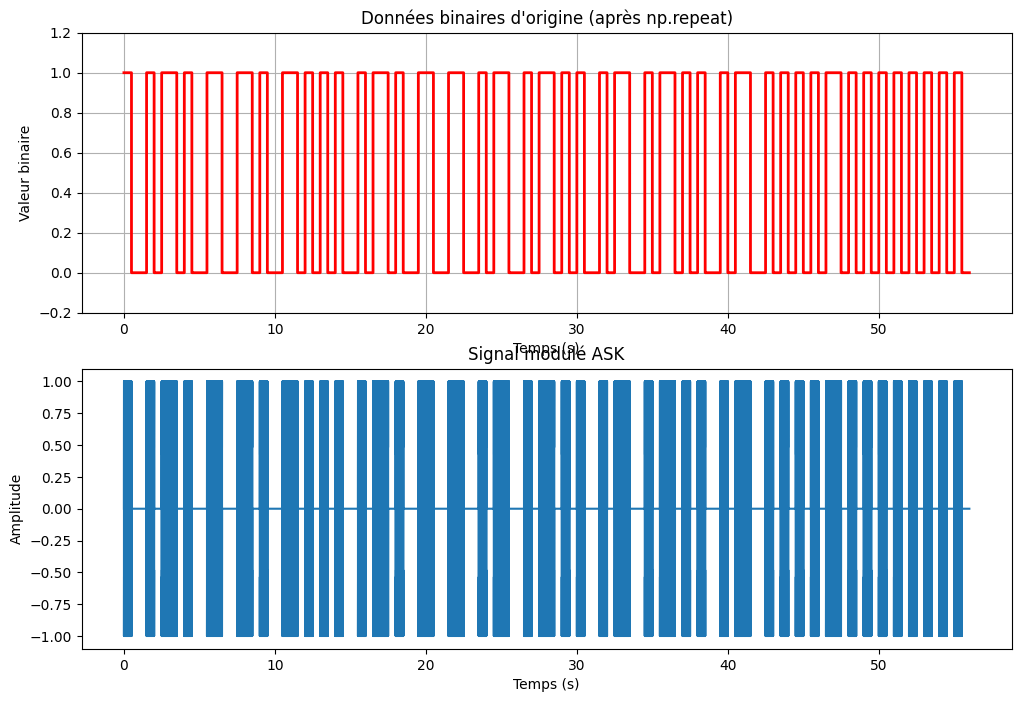

In [217]:
# Émission d'un message en ASK

Msg = "Hello"
print(f"Message original : {Msg}")  # Affichage du message initial

Msg = texte_en_binaire(Msg)  # Conversion du message en binaire
print(f"Message original converti en binaire : {Msg}")

Tramed_MSG = add_trame_to_message(Msg)  # Ajout de la trame (préfixe, suffixe, CRC)
print(f"Message avec trame : {Tramed_MSG}")

Coded_MSG = codage(Tramed_MSG)  # Codage Manchester du message
print(f"Message codé : {Coded_MSG}")

ASK = ModulationASK(Coded_MSG, Fp=500, baud=2)  # Modulation du message en ASK


### Reception

In [218]:
# Réception d'un message en ASK


Demod = DemodulationASK(ASK, Fp=500, baud=2)  # Démodulation du signal ASK
print(f"Message démodulé : {Demod}")

Decod = decodage(Demod)  # Décodage Manchester
print(f"Message décodé : {Decod}")

Untram = retrieve_message_from_trame(Decod)  # Suppression de la trame
print(f"Message sans trame : {Untram}")

print(f"Message final : {binaire_en_texte(Untram)}")  # Conversion du binaire en texte


Message démodulé : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Message décodé : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
📥 CRC reçu : 0 | 🛠️ CRC calculé : 0
✅ CRC validé avec succès.
Message sans trame : [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
Message final : Hello


## Tester la Modulation/Démodulation FSK

##### **Pourquoi utiliser `(Fp1 = 20,Fp2 = 60, baud = 20)` ?**  

- Pour obtenir des graphiques **clairs et visibles**.  
- Pour s'assurer que la **démodulation fonctionne correctement** avec un **nombre minimal de bits**.  

##### **Pourquoi le message Msg = "M" ?**  
- Pour obtenir des graphiques **clairs et visibles** (il est possible d'envoyer un message plus long).

### Emission

Message original : M
Message original converti en binaire : [0, 1, 0, 0, 1, 1, 0, 1]
Message avec trame : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Message codé : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


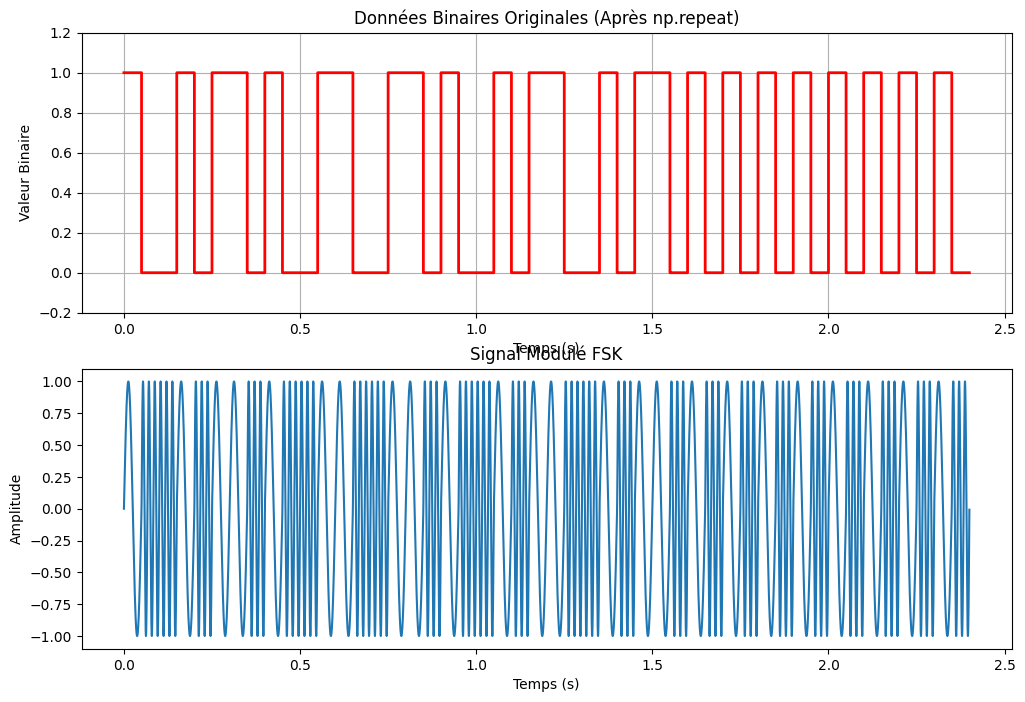

In [220]:
# Émission d'un message en FSK

Msg = "M"
print(f"Message original : {Msg}")

Msg = texte_en_binaire(Msg)  # Conversion du texte en binaire
print(f"Message original converti en binaire : {Msg}")

Tramed_MSG = add_trame_to_message(Msg)  # Ajout de la trame
print(f"Message avec trame : {Tramed_MSG}")

Coded_MSG = codage(Tramed_MSG)  # Codage Manchester
print(f"Message codé : {Coded_MSG}")

FSK = ModulationFSK(Coded_MSG, Fp1=20, Fp2=60, baud=20)  # Modulation FSK


### Reception

In [221]:
# Réception du message en FSK

Demod = DemodulationFSK(FSK, Fp1=20, Fp2=60, baud=20)  # Démodulation FSK
print(f"Message démodulé : {Demod}")

Decod = decodage(Demod)  # Décodage Manchester
print(f"Message décodé : {Decod}")

Untram = retrieve_message_from_trame(Decod)  # Suppression de la trame
print(f"Message sans trame : {Untram}")

print(f"Message final : {binaire_en_texte(Untram)}")  # Conversion binaire → texte


Message démodulé : [1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0]
Message décodé : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
📥 CRC reçu : 0 | 🛠️ CRC calculé : 0
✅ CRC validé avec succès.
Message sans trame : [0, 1, 0, 0, 1, 1, 0, 1]
Message final : M


## Tester l'écoute du son ASK (Utilisé pour le transfer de l'information entre deux PCs via son)

##### **Pourquoi utiliser `(Fp = 500, baud = 2)` ?**  
- Pour obtenir des graphiques **clairs et visibles**.  
- Pour s'assurer que la **démodulation fonctionne correctement** avec un **nombre minimal de bits**.  
- Pour pouvoir **entendre** le son et mieux comprendre comment le **système fonctionne**.  

##### **Comment tester l'écoute du son ?**  
- Il faut d'abord lancer **"PC 2" (récepteur)** et attendre que **"Prêt à enregistrer"** soit affiché dans sa sortie.  
- Ensuite, sans faire trop de bruit, lancer le code du **"PC 1" (émetteur)** et attendre que le son soit joué entièrement.  
- Avec un peu de chance, l'enregistrement du **"PC 2" (récepteur)** devrait s'arrêter, et vous pourrez voir le message du **"PC 1"** dans sa sortie.  


### PC 1

Message original : Groupe 4
Message original converti en binaire : [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
Message avec Trame : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Message Codé : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 

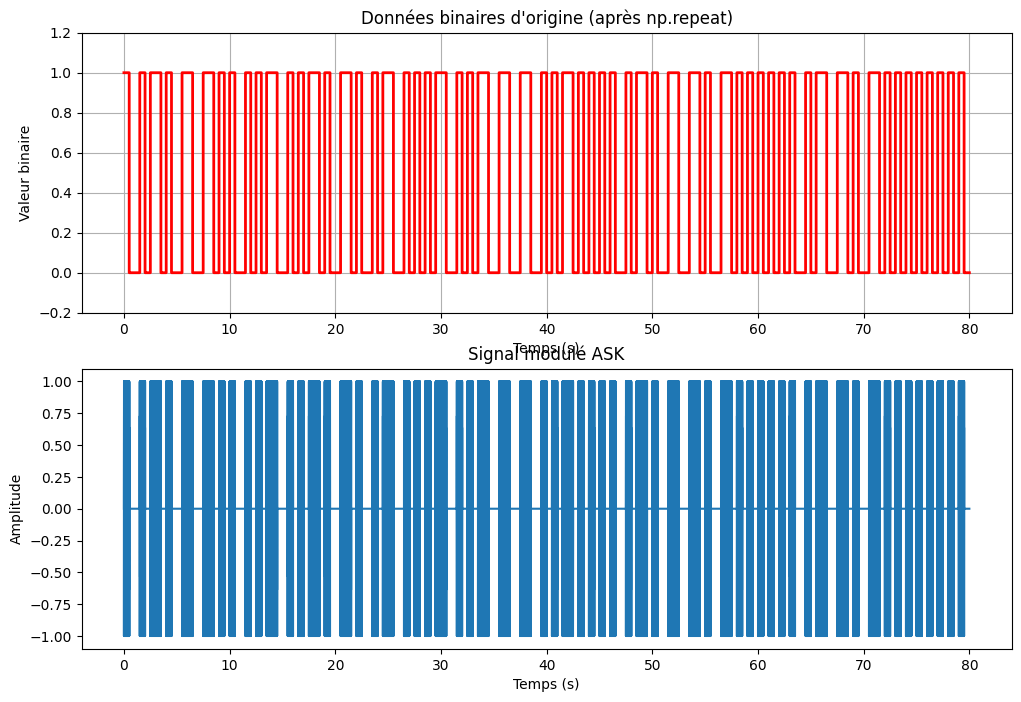

In [192]:
# PC Envoyeur

import sounddevice as sd

def Accuse_de_reception(Retour):
    """
    Vérifie l'accusé de réception du message reçu.
    """
    Demod = DemodulationASK(Retour)  # Démodulation du signal de retour

    if Demod[2] == 0:
        print("Le message a été reçu par PC 1 avec erreurs.")
    elif Demod[2] == 1:
        print("Le message a été reçu par PC 1 sans erreurs.")

ThreadPC2 = None  # Initialisation du thread du PC 2

# Message à envoyer
Msg = "Groupe 4"
print(f"Message original : {Msg}")

# Conversion du message en binaire
Msg = texte_en_binaire(Msg)
print(f"Message original converti en binaire : {Msg}")

# Ajout de la trame
Tramed_MSG = add_trame_to_message(Msg)
print(f"Message avec Trame : {Tramed_MSG}")

# Codage Manchester
Coded_MSG = codage(Tramed_MSG)
print(f"Message Codé : {Coded_MSG}")

# Modulation ASK
ASK = ModulationASK(Coded_MSG, Fp=500, baud=2)

# Émission du signal sonore

PlaySound(ASK)

print("✅ Transmission terminée.")



### PC 2

In [ ]:
# PC Récepteur

import sounddevice as sd
import threading
import time

ThreadPC2 = None  # Initialisation du thread du PC 1

def Recevoir():
    """
    Fonction de réception du message via microphone et traitement du signal.
    """
    Recu = Listen_MIC([500])  # Écoute du signal ASK
    Demod = DemodulationASK(Recu, Fp=500, baud=2)  # Démodulation du signal
    print(f"Message démodulé : {Demod}")

    # Décodage Manchester
    Decod = decodage(Demod)
    print(f"Message décodé : {Decod}")

    # Suppression de la trame
    Untram = retrieve_message_from_trame(Decod)
    print(f"Message sans trame : {Untram}")

    # Conversion du binaire en texte
    print(f"Message Démodulé : {binaire_en_texte(Untram)}")

    # Envoi de l'accusé de réception
    if Untram:
        Accuse_de_reception(ModulationASK([1, 0, 1, 0, 1]))  # Signal de confirmation
    else:
        Accuse_de_reception(ModulationASK([1, 0, 0, 0, 1]))  # Signal d'erreur

    ThreadPC2 = None  # Réinitialisation du thread après exécution

# Démarrage de la réception dans un thread

ThreadPC2 = threading.Thread(target=Recevoir, daemon=True).start()


Calibration...
Prêt à enregistrer (Attente du message).
Message démodulé : [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Message décodé : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Conclusion  

Notre prototype démontre la faisabilité de notre proposition. Il incorpore :  
- Deux types de **modulation/démodulation** (ASK & FSK).  
- La gestion de la **réception d'un signal avec bruit** (filtrage du signal lors de son écoute).  
- L'utilisation d'une **liaison half-duplex avec accusé de réception** (confirmation que le message est parvenu au **PC 2** sans erreurs).  
- Un **CRC** ou un **code de correction d'erreur** (inclus dans la partie d'ajout/retrait de trame).  
- La **simulation entre deux PC** (possible grâce au **système d'écoute du microphone**). De plus, notre groupe a développé un **logiciel additionnel** qui assure la communication entre deux PC en utilisant le même code.  


